# Run CNN on FFT instead of MFCC

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import json
from torchsummary import summary
import time
from sklearn.preprocessing import LabelEncoder
import librosa.display
import math
import os
from textwrap import dedent

IRMAS_PATH = "/content/drive/MyDrive/ITCS 5156 project/IRMAS dataset/IRMAS-TrainingData/"
JSON_PATH = "/content/drive/MyDrive/ITCS 5156 project/IRMAS dataset/json_files/"
filename = "irmas_data_mfcc13_hop_length256_n_fft2048.json"

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [9]:
class IRMASDataset(Dataset):
  def __init__(self, JSON_PATH, filename, transform=None):
    with open(JSON_PATH + filename, "r") as f:
      self.irmas_data = json.load(f)
    self.metadata = self.irmas_data.pop('metadata') 
    self.instruments = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax",
    "tru", "vio", "voi"]
    self.encoder = LabelEncoder()
    self.encoder.fit(self.instruments)

  def __len__(self):
    return len(self.irmas_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = np.array(idx.tolist())

    mfccs = np.array(self.irmas_data[str(idx)]['mfccs'])[np.newaxis,...]

    primary_instrument = self.encoder.transform(
      [np.array(self.irmas_data[str(idx)]['primary_instrument'])]
    )
    sample = {'mfccs': mfccs, 'instrument': primary_instrument, 'metadata': self.metadata}
    return sample

In [26]:
paths = []
# https://stackoverflow.com/a/16465439
for root, dirs, files in os.walk(IRMAS_PATH):
  for file in files:    
    if file.endswith('.wav'):
      paths.append(os.path.join(root, file))

In [29]:
paths[0].split("/")[-2]

'cla'

In [30]:
class IRMASDataset_fft(Dataset):
  def __init__(self, IRMAS_PATH, hop_length=512, n_fft=2048, transform=None):
    
    # get filepaths
    self.paths = []
    # https://stackoverflow.com/a/16465439
    for root, dirs, files in os.walk(IRMAS_PATH):
      for file in files:    
        if file.endswith('.wav'):
          self.paths.append(os.path.join(root, file))

    # encode targets
    self.instruments = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax",
    "tru", "vio", "voi"]
    self.encoder = LabelEncoder()
    self.encoder.fit(self.instruments)

    # fft params
    self.hop_length = hop_length
    self.n_fft = n_fft

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = np.array(idx.tolist())
    
    # load the audio file
    signal, sr = librosa.load(self.paths[idx], sr=44100)

    # calculate fft
    stft = librosa.core.stft(signal, hop_length=self.hop_length, n_fft=self.n_fft)
    spectrogram = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    # labels
    primary_instrument = self.encoder.transform(
      [np.array(paths[idx].split("/")[-2])]
    )

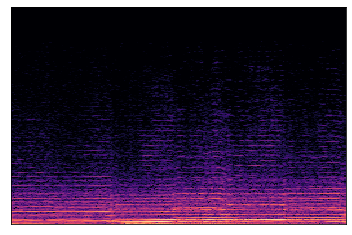

In [8]:
test_file = IRMAS_PATH + "cel/008__[cel][nod][cla]0058__1.wav"
hop_length = 512
n_fft = 2048
signal, sr = librosa.load(test_file, sr=44100)
stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)
log_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)

In [24]:
type(log_spectrogram)

numpy.ndarray